In [ ]:
!pip install deap faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.1 MB/s eta 0:00:00


## Solid

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[[0.9958776103000166, 0.9943176726257674, 0.041939375830039594, 0.0239809247893622, 0.00793853164851413, 0.06515989320682947, 0.04643092970545726, 0.016262591161211093, -0.014663036840061254, 0.013694623811532969], [0.9958776103000166, 0.9943176726257674, 0.041939375830039594, 0.0239809247893622, 0.021530587551698233, 0.06515989320682947, 0.04643092970545726, 0.016262591161211093, -0.014663036840061254, 0.013694623811532969], [0.9958776103000166, 0.9943176726257674, 0.041939375830039594, 0.0239809247893622, 0.00793853164851413, 0.06515989320682947, 0.04643092970545726, 0.016262591161211093, -0.014663036840061254, 0.013694623811532969], [0.9958776103000166, 0.9943176726257674, 0.041939375830039594, 0.0239809247893622, 0.00793853164851413, 0.06515989320682947, 0.04643092970545726, 0.016262591161211093, -0.014663036840061254, 0.013694623811532969], [0.9958776103000166, 0.9943176726257674, 0.041939375830039594, 0.0239809247893622, 0.021530587551698233, 0.06515989320682947, 0.04643092970545

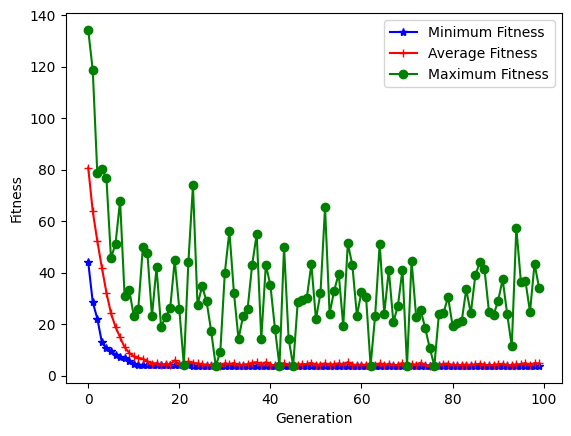

In [ ]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt

class Setup:
    def __init__(self):
        self.CXPB, self.MUTPB, self.NGEN, self.POP_SIZE = 0.9, 0.05, 100, 100
        self.IND_SIZE = 10

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()
        self.toolbox.register("attribute", random.random)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attribute, n=self.IND_SIZE)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate)

    def evaluate(self, individual):
        rastrigin = 10 * self.IND_SIZE
        for i in range(self.IND_SIZE):
            rastrigin += (individual[i]*individual[i] - 10 * (math.cos(2*np.pi*individual[i])))
        return rastrigin


class AlgEvolution:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)
        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.pop = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.pop)

    def run(self):
        # Evaluate the entire population
        fitnesses = map(self.setup.toolbox.evaluate, self.pop)
        for ind, fit in zip(self.pop, fitnesses):
            ind.fitness.values = [fit]

        # Generational loop until stop criteria
        for g in range(self.setup.NGEN):
            # Select the next generation individuals
            offspring = self.setup.toolbox.select(self.pop, k=len(self.pop))
            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            # The population is entirely replaced by the offspring
            self.pop[:] = offspring

            # Elitism
            # Update best with new pop
            self.hof.update(self.pop)

            # Update pop with best
            self.pop[0] = self.setup.toolbox.clone(self.hof[0])

            # Save each generation record in the logbook
            record = self.stats.compile(self.pop)
            self.logbook.record(gen=g, **record)

        return self.pop, self.logbook, self.hof[0]


class DataExploration:
    @staticmethod
    def visualize(logbook,pop):
        gen = logbook.select("gen")
        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        best_solution_index = fit_min.index(min(fit_min))
        best_solution_variables = pop[best_solution_index]
        best_solution_fitness = fit_min[best_solution_index]

        print("Best solution variables \n", best_solution_variables)
        print("Best solution fitness \n", best_solution_fitness)

        fig, ax1 = plt.subplots()
        line1 = ax1.plot(gen, fit_min, "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, fit_avg, "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, fit_max, "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")
        plt.show()



def main():
    setup = Setup()
    alg = AlgEvolution(setup)
    pop, logbook, best = alg.run()
    #print("Best solution variables \n", best)
    #print("Best solution fitness \n", best.fitness)

    DataExploration.visualize(logbook,pop)


if __name__ == "__main__":
    main()


## Pedro

1. Otimização do desempenho de geradores eólicos e fotovoltaicos:

Objetivo: Maximizar a geração de energia considerando restrições operacionais (velocidade do vento, irradiação solar, limites de potência).
Variáveis Individuais: Ângulo da pá do rotor (eólico), ângulo de inclinação do painel (fotovoltaico).
Função de Avaliação: Potência gerada menos penalidades por violação de restrições.
Exemplos de uso:
Aumentar a geração de energia de um parque eólico durante uma rajada de vento.
Maximizar a produção de energia solar em diferentes horários do dia.
2. Controle de turbinas eólicas:

Objetivo: Manter a velocidade de rotação da turbina em torno de um valor de referência, considerando perturbações de vento.
Variáveis Individuais: Ganho do controlador de passo da pá.
Função de Avaliação: Desvio da velocidade de rotação em relação ao valor de referência.
Exemplos de uso:
Adaptar o controle da turbina a diferentes condições de vento.
Reduzir o desgaste mecânico da turbina minimizando oscilações de velocidade.
3. Sincronização de geradores:

Objetivo: Alcançar e manter a mesma frequência e fase entre dois ou mais geradores conectados à rede.
Variáveis Individuais: Ajustes de ângulo de fase e frequência nas excitatrizes dos geradores.
Função de Avaliação: Diferença de frequência e fase entre os geradores.
Exemplos de uso:
Sincronizar um novo gerador à rede elétrica.
Manter a estabilidade da rede em caso de perturbações.

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



--------- Generation 1 ---------

Dados da geração 1 : {'avg': 186.68408260539866, 'min': 117.59963858609247, 'max': 275.49669915508235}
[[-0.9147434851449736, -1.4918593600073962, -0.21190968096508556, 0.4677078224900635, -0.9295706774492709, -0.8435412458343352, -1.552358528438404, -2.1108778655574567, -0.0469636478799913, 2.7434892680574237]]
[-4.01, -2.26, 2.98, 0.26, 2.0, -3.55, 0.49, 0.11, -2.57, 2.53]

Best individual: Brian Ross, Genes: [-4.01, -2.26, 2.98, 0.26, 2.0, -3.55, 0.49, 0.11, -2.57, 2.53],Fitness: 106.16187341252386, SumEvaluate: -4.02

--------- Generation 2 ---------

Dados da geração 2 : {'avg': 157.50483975729827, 'min': 106.16187341252386, 'max': 208.11714552434307}
[[-0.9147434851449736, -1.4918593600073962, -0.21190968096508556, 0.4677078224900635, -0.9295706774492709, -0.8435412458343352, -1.552358528438404, -2.1108778655574567, -0.0469636478799913, 2.7434892680574237]]
[-4.01, -2.26, 2.98, 0.26, 2.0, -3.55, 0.49, 0.11, -2.57, 2.53]

Best individual: Brian R

,Generation,Best,Mean,Minimum,Maximum
0,1.0,275.496699,186.684083,117.599639,275.496699
1,2.0,208.117146,157.504840,106.161873,208.117146
2,3.0,159.304237,134.739188,109.357029,159.304237
3,4.0,139.891547,122.568444,109.357029,139.891547
4,5.0,126.820218,118.489996,108.973411,126.820218
...,...,...,...,...,...
95,96.0,49.284405,46.620169,46.341770,49.284405
96,97.0,60.313989,47.188491,46.341770,60.313989
97,98.0,48.870390,46.468201,46.341770,48.870390
98,99.0,88.942118,48.832685,46.341770,88.942118


,Generation,Nome,Fitness,FitnessRastrigin,FitnessSum
0,1,Brian Ross,106.161873,162.007439,-4.02
1,2,Brian Ross,106.161873,162.007439,-4.02
2,3,Brian Ross,106.161873,162.007439,-4.02
3,4,Brian Ross,106.161873,162.007439,-4.02
4,5,Brian Ross,101.032957,162.007439,-4.02
...,...,...,...,...,...
95,96,Brian Ross,46.341770,162.007439,-4.02
96,97,Brian Ross,46.341770,162.007439,-4.02
97,98,Brian Ross,46.341770,162.007439,-4.02
98,99,Brian Ross,46.341770,162.007439,-4.02


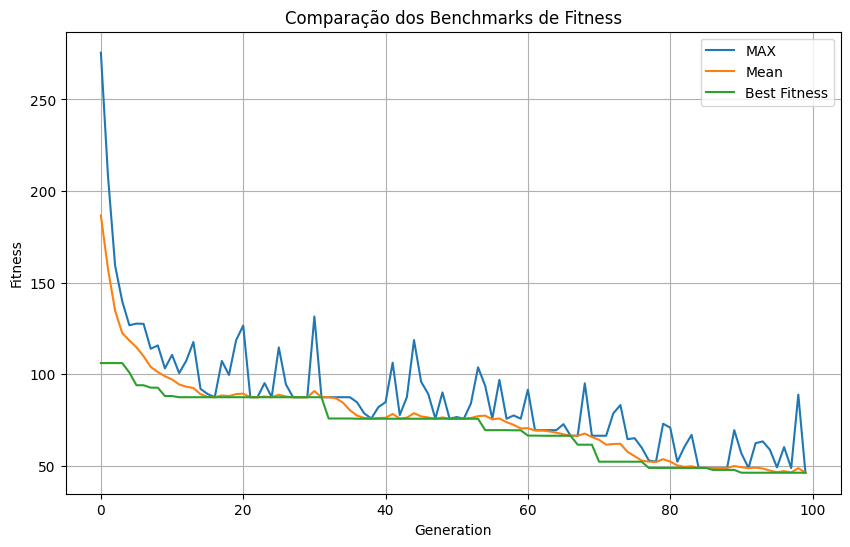

In [ ]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
import pandas as pd
from faker import Faker
import matplotlib.pyplot as plt
import json

# Faker for names
fake = Faker(['en_US','pt_BR','it_IT'])

used_names = set()

def generate_unique_name():
    while True:
        name = fake.name()
        if name not in used_names:
            used_names.add(name)
            return name

def initIndividual(genes):
    # Generate random genes of desired length
    genes = [random.randint(0,1) for _ in range(10)]
    return creator.Individual(genes=genes, name=generate_unique_name)


# Individual generator that includes unique name assignment
def create_unique_individual():
    individual = toolbox.individual()
    individual.genes = [round(random.uniform(-5,5),2) for _ in range(10)]
    individual.name = generate_unique_name()
    return individual

def repopulate_with_elite(population, elite_individuals, elite_size):
    """
    Substitui os indivíduos menos aptos da população atual pelos melhores indivíduos (elite).
    """
    # Ordena a população atual pelo fitness (do pior para o melhor)
    sorted_population = sorted(population, key=lambda ind: ind.fitness.values, reverse=True)

    # Substitui os menos aptos pelos indivíduos elite
    sorted_population[:elite_size] = elite_individuals[:elite_size]

    return sorted_population

def remove_and_replace_duplicates(population):
    # Armazena indivíduos únicos baseando-se em nome e valor de fitness.
    unique_combinations = set()
    new_population = []

    for ind in population:
        # Avalia o fitness se ainda não foi avaliado.
        if not ind.fitness.valid:
            ind.fitness.values = toolbox.evaluate(ind)

        # Cria uma chave única baseando-se no nome e fitness.
        key = (ind.name, ind.fitness.values)

        if key not in unique_combinations:
            unique_combinations.add(key)
            new_population.append(ind)
        else:
            # Gera e avalia novos indivíduos até encontrar um único.
            unique_found = False
            while not unique_found:
                new_ind = create_unique_individual()
                new_ind.fitness.values = toolbox.evaluate(new_ind)
                new_key = (new_ind.name, new_ind.fitness.values)

                if new_key not in unique_combinations:
                    unique_combinations.add(new_key)
                    new_population.append(new_ind)
                    unique_found = True

    return new_population



def evaluateInd(individual):
    return sum(individual),

def rastrigin_fitness(individual):
    A = 10
    n = len(individual.genes)
    return A*n + sum(x**2 - A * np.cos(2 * np.pi * x) for x in individual.genes),

def sum_fitness(individual):
    return sum(individual.genes),

# Rastrigin function
def rastrigin(individual):
    A = 10
    n = len(individual)
    return A*n + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in individual]),

def evaluate_composite(individual):
    # Avalia o indivíduo usando a função de Rastrigin
    fitness_rastrigin = rastrigin_fitness(individual)[0]

    # Avalia o indivíduo usando a função de soma
    fitness_sum = sum_fitness(individual)[0]

    # Retorna os resultados como um dicionário para facilitar o acesso
    return {'rastrigin_genes': fitness_rastrigin, 'sum': fitness_sum}

def rosenbrock(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

# Constantes
POP_SIZE = 20  # Tamanho da população
CROSSOVER = 0.9  # Probabilidade de crossover
MUTATION = 0.05  # Probabilidade de mutação
GENERATIONS = 100  # Número de gerações


best_population = []
dados = {}

# Assuming you have already created the Fitness and Individual classes with DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
# Adjust attribute generator for float values in the range [-5, 5]
toolbox.register("attr_float", random.uniform, -5, 5)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=10)


toolbox.register("population", tools.initRepeat, list, create_unique_individual, n=10)


# Evaluation
toolbox.register("evaluate", rastrigin)
toolbox.register("evaluate_rastrigin", rastrigin_fitness)
toolbox.register("evaluate_sum", sum_fitness)

# Genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Elitism
IND_ELITE = tools.HallOfFame(1)




# Statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

def main():
    pop = toolbox.population(n=POP_SIZE)


    # Initialize fitness, generate names, and collect data
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):

        #Funcoes objetivos
        try:
            fitness_results = evaluate_composite(ind)
            ind.rastrigin_fitness = fitness_results['rastrigin_genes']  # Armazenamento personalizado
            ind.sum_fitness = fitness_results['sum']
        except:
            print('\nerro')

        #Dados individuo
        ind.fitness.values = fit
        #print("\n\nDEBUG",ind.name, fit)
        ind.name = fake.name()

    df = pd.DataFrame(columns=["Generation","Best", "Mean", "Minimum", "Maximum"])

    # Evolution
    for gen in range(GENERATIONS):
        dados = {}
        print(f"\n--------- Generation {gen+1} ---------")

        # Imprime a população
        for ind_num, ind in enumerate(pop):
            pass
            #print(f"Indivíduo {ind_num}: {ind.name}, Fitness: {ind.fitness.values}")

        # Elitism (update HOF and select best next generation)
        offspring = toolbox.select(pop, k=len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Collect statistics
        stats_data = stats.compile(pop)
        print("\nDados da geração", gen+1, ":", stats_data)
        df.loc[gen] = [gen+1, stats_data["max"], stats_data["avg"], stats_data["min"], stats_data["max"]]

        # Crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSSOVER:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTATION:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate invalid individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit


        #Selecionando o conjunto elite
        #pop = tools.selBest(pop + offspring, k=POP_SIZE)
        IND_ELITE.update(offspring)
        print(IND_ELITE)
        print(IND_ELITE.items[0].genes)

        print(f"\nBest individual: {IND_ELITE.items[0].name}, Genes: {IND_ELITE.items[0].genes},Fitness: {IND_ELITE.items[0].fitness.values[0]}, SumEvaluate: {sum(IND_ELITE.items[0].genes)}")
        #df['Name'] = hof.items[0].name
        dados["Generation"] = gen+1
        dados["Nome"] = IND_ELITE.items[0].name
        dados["Fitness"] = IND_ELITE.items[0].fitness.values[0]


        try:
            dados["FitnessRastrigin"] = IND_ELITE.items[0].rastrigin_fitness
            dados["FitnessSum"] = IND_ELITE.items[0].sum_fitness

        except:
            print('\n\nerro 2 ')
        best_population.append(dados)

        pop[:] = offspring



    # Results and plot
    display(df)
    df.to_excel("./results.xlsx")
    best_population_df = pd.read_json(
        json.dumps(best_population),
        orient="records"

    )
    display(best_population_df)



    #plot
    plt.figure(figsize=(10, 6))
    plt.plot(df["Best"], label="MAX")
    plt.plot(df["Mean"], label="Mean")
    plt.plot(best_population_df["Fitness"], label="Best Fitness")
    #plt.plot(best_population_df["FitnessRastrigin"], label="Fitness Rastrigin")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.title('Comparação dos Benchmarks de Fitness')
    plt.grid(True)

    plt.show()

if __name__ == "__main__":
    main()


## Rainer

In [ ]:
import numpy as np
import math
from deap import base, creator, tools
import random

#GA parameters
CXPB, MUTPB, NGEN, POP_SIZE = 0.9, 0.05, 100, 100
IND_SIZE = 10 #number of decision variables

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attribute", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,toolbox.attribute, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
#fitness function
def evaluate(individual):
    rastrigin = 10 * IND_SIZE
    for i in range(IND_SIZE):
      rastrigin += (individual[i]*individual[i] - 10 * (math.cos(2*np.pi*individual[i])))
    return rastrigin,

In [ ]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [ ]:
def main():
    #store statistics of all generations
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()

    #GA initial population
    pop = toolbox.population(n=POP_SIZE)

    #store best individual
    hof = tools.HallOfFame(1)
    hof.update(pop)

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    #generational loop until stop criteria
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, k=len(pop))
        # Clone the selected individuals
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        #Elitism
        #update best with new pop
        hof.update(pop)
        #update pop with best
        pop[0] = toolbox.clone(hof[0])
        #print(hof[0])
        #print(hof[0].fitness.valid)
        #print(hof[0].fitness)

        #save each generation record in the logbook
        record = stats.compile(pop)
        logbook.record(gen=g, **record)

    return pop,logbook,hof[0]

In [ ]:
#call the EA
pop,logbook,best = main()

#read the logbook
gen = logbook.select("gen")
fit_avg = logbook.select("avg")
fit_std = logbook.select("std")
fit_min = logbook.select("min")
fit_max = logbook.select("max")

#print best individual
print("best solution variables \n", best)
#print best fitness
print("best solution fitness \n",best.fitness)

#plot
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_min, "*b-", label="Minimum Fitness")
line2 = ax1.plot(gen, fit_avg, "+r-", label="Average Fitness")
line3 = ax1.plot(gen, fit_max, "og-", label="Maximum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
lns = line1 + line2 + line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")
plt.show()

AttributeError: 'Toolbox' object has no attribute 'evaluate'